# Scoring (Unseen Data)

In [95]:
import joblib
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [96]:
path = "/data/"
#unseen or new dataset
data = pd.read_csv(path+'test.csv')

print(data.shape)
data.head(10)

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,763.0,763.0,GasA,Gd,Y,SBrkr,763,892,0,1655,0.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,Fin,2.0,440.0,TA,TA,Y,157,84,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1467,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,7,1992,2007,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Gd,PConc,Gd,TA,No,ALQ,935.0,Unf,0.0,233.0,1168.0,GasA,Ex,Y,SBrkr,1187,0,0,1187,1.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Attchd,1992.0,Fin,2.0,420.0,TA,TA,Y,483,21,0,0,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,789.0,789.0,GasA,Gd,Y,SBrkr,789,676,0,1465,0.0,0.0,2,1,3,1,TA,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,393.0,TA,TA,Y,0,75,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,1469,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,1990,1990,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,Gd,GLQ,637.0,Unf,0.0,663.0,1300.0,GasA,Gd,Y,SBrkr,1341,0,0,1341,1.0,0.0,1,1,2,1,Gd,5,Typ,1,Po,Attchd,1990.0,Unf,2.0,506.0,TA,TA,Y,192,0,0,0,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,1470,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,

In [97]:
data.drop('Id',axis=1,inplace=True)
data.shape

(1459, 79)

### Feature Engineering
Transforming data 

Llist of transformations that I did during Feature Engineering phase:

1. `Missing values treatment`
2. `Temporal variables adjsutment`
3. `Non-Gaussian distributed variables treatment`
4. `Categorical variables:` `remove rare labels`,`convert strings to numbers`
5. `Scalling`


### 1.1. Missing in `Categorical variables`

Replacing missing values
* with string `missing` in those variables with a lot of missing data
* with `most frequent category` in those variables that contain fewer observations without values

In [98]:
#cast MSSubClass as object
data['MSSubClass'] = data['MSSubClass'].astype('O')

In [99]:
#list : different groups of categorical variables

with_string_missing = ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature']

See how I have to hardencode 

* I have to copy bellow seen dictionary from Feature_Engineering notebook
    * note that I have to hard-code this by hand

* `key` is the variable and `value` is its most frequent category

**`Problem:`** What if we re-train model and below values change?

In [100]:
with_frequent_category = {'MasVnrType':'None','BsmtQual':'TA',
                          'BsmtCond':'TA','BsmtExposure':'No',
                          'BsmtFinType1':'Unf','BsmtFinType2':'Unf',
                          'Electrical':'SBrkr','GarageType':'Attchd',
                          'GarageFinish':'Unf','GarageQual':'TA',
                          'GarageCond':'TA',
                         }

In [101]:
#replacing missing values with new label: "Missing"

data[with_string_missing] = data[with_string_missing].fillna('Missing')

#replacing missing values with most frequent category

for var in with_frequent_category.keys():
    data[var].fillna(with_frequent_category[var], inplace=True)

### 1.2. Missing in Numerical variables
Handling missing values in numerical variables by:

* adding a `Binary missing value` indicator variable
* Replace missing values in original variable with `mean`


In [102]:
#NOTE :  I have to hard code these values [Pipeline]
vars_with_na = {"LotFrontage":70.36715867158672,
                "MasVnrArea":104.36648814078042,
                "GarageYrBlt":1978.2495961227787
               }

# this dictionary is of numerical variable with missing data and its mean, 
## as determined from training set in Feature_Engineering notebook

In [103]:
#replacing missing values

for var in vars_with_na.keys():
    #adding binary missing indicator (in train and test)
    data[var + '_na'] = np.where(data[var].isnull(),1,0)
    # replace missing values by mean (in train & test)
    data[var].fillna(vars_with_na[var],inplace=True)

data[vars_with_na].isnull().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [104]:
#checking binary missing indicator variables
data[['LotFrontage_na','MasVnrArea_na','GarageYrBlt_na']].head()

,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


## 2. Temporal variables
### 2.1. Capture elapsed time
Let's capture time elapsed between those variables and year in which house was sold

In [105]:
def elapsed_years(df, var):
    #capturing difference between year variable &
    # and year in which house was sold
    df[var] = df['YrSold'] - df[var]
    return df

In [106]:
for feature in ['YearBuilt','YearRemodAdd','GarageYrBlt']:
    data = elapsed_years(data,feature)

In [107]:
#droping YrSold
data.drop(['YrSold'],axis=1,inplace=True)

## 3. Variables Transformation (Numerical)
### 3.1. Logarithmic Transformation
I will transform with `Logarithm`, the positive numerical variables in order to get almost Gaussian Like distribution

In [108]:
for feature in ["LotFrontage","1stFlrSF","GrLivArea"]:
    data[feature] = np.log(data[feature])

### 3.2. Yeo-Johnson transformation
Apply Yeo-Johnson transformation on `LotArea`

In [109]:
# note how we use lambda that we learned from train set, from Feature Engineering notebook

#NOTE: I have to hard code this value

data['LotArea'] = stats.yeojohnson(data['LotArea'],lmbda=-12.55283001172003)

### 3.3. Binarize skewed variables
I have seen few variables very skewed, thinking to transform those into `Binary Variables`

In [110]:
skewed = ['BsmtFinSF2','LowQualFinSF','EnclosedPorch',
          '3SsnPorch','ScreenPorch','MiscVal']

for feature in skewed:    
    #mapping variable values into 0 and 1
    data[feature] = np.where(data[feature]==0,0,1)

## 4. Categorical variables
### 4.1. Apply mappings
Remap variables with specific meanings into a numerical scale

In [111]:
#re-mapping strings to numbers, which determine quality
qual_vars = ['ExterQual','ExterCond', 'BsmtQual','BsmtCond','HeatingQC',
             'KitchenQual','FireplaceQu','GarageQual', 'GarageCond',]
qual_mappings = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5, 'Missing':0, 'NA':0}

for feature in qual_vars:
    data[feature] = data[feature].map(qual_mappings)

In [112]:
var = 'BsmtExposure'
exposure_mappings = {'No':1, 'Mn':2, 'Av':3, 'Gd':4}

data[var] = data[var].map(exposure_mappings)

In [113]:
finish_vars = ['BsmtFinType1','BsmtFinType2']
finish_mappings = {'Missing':0, 'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}

for feature in finish_vars:
    data[feature] = data[feature].map(finish_mappings)

In [114]:
feature = 'GarageFinish'
garage_mappings = {'Missing':0, 'NA':0, 'Unf':1, 'RFn':2, 'Fin':3}

data[feature] = data[feature].map(garage_mappings)

In [115]:
feature = 'Fence'
fence_mappings = {'Missing':0, 'NA':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}

data[feature] = data[feature].map(fence_mappings)

In [116]:
#checking absence of na in data set

with_null = [feature for feature in data.columns if data[feature].isnull().sum() > 0]
print(with_null)

['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageCars', 'GarageArea', 'SaleType']


**`Observation:`**

Quite a few variables with missing data!!!!!

In [117]:
# did those have missing data in the train set?

[feature for feature in with_null if feature in \
 list(with_frequent_category.keys())+with_string_missing+list(vars_with_na.keys())]

[]

**`NOTE:`**

In new data, I can observe `bunch of variables that contain missing information`, I was not anticipating this!!!

### 4.2. Removing Rare Labels
For remaining categorical variables
* I am groupping those categories that are present in `less than 1% of observations` into a "Rare" string


I have to create a `dictionary with most frequent categories per variable`
    * Problem is amount of hard coding that I need to go though

* Good alternative, would be if I would have saved this as a numpy pickle in FeatUure Engineering nptebook and load it here, instead of hard-coding
* This means that I need to go back to Feature Engineering notebook, and change some code so that I can store pickle
    * `So there is still some code changes that I need`

In [118]:
frequent_ls = {
    'Street': ['Pave'],
    'PoolQC': ['Missing'],
    'Condition2': ['Norm'],
    'Utilities': ['AllPub'],
    'RoofMatl': ['CompShg'],
    'CentralAir': ['N','Y'],
    'LandSlope': ['Gtl','Mod'],
    'Heating': ['GasA','GasW'],
    'PavedDrive': ['N','P','Y'],
    'RoofStyle': ['Gable','Hip'],
    'SaleType': ['COD','New','WD'],
    'LotShape': ['IR1','IR2','Reg'],
    'MiscFeature': ['Missing','Shed'],
    'MSZoning': ['FV','RH','RL','RM'],
    'Alley': ['Grvl','Missing','Pave'],
    'Electrical': ['FuseA','FuseF','SBrkr'],
    'MasVnrType': ['BrkFace','None','Stone'],
    'LandContour': ['Bnk','HLS','Low','Lvl'],
    'Functional': ['Min1','Min2','Mod','Typ'],
    'Foundation': ['BrkTil','CBlock','PConc','Slab'],
    'LotConfig': ['Corner','CulDSac','FR2','Inside'],
    'GarageType': ['Attchd','Basment','BuiltIn','Detchd'],
    'Condition1': ['Artery','Feedr','Norm','PosN','RRAn'],
    'BldgType': ['1Fam','2fmCon','Duplex','Twnhs','TwnhsE'],
    'SaleCondition': ['Abnorml','Family','Normal','Partial'],
    'HouseStyle': ['1.5Fin','1Story','2Story','SFoyer','SLvl'],
    'MSSubClass': ['20','30','50','60','70','75','80','85','90','120','160','190'],
    'Exterior1st': ['AsbShng','BrkFace','CemntBd','HdBoard','MetalSd','Plywood',
                    'Stucco','VinylSd','Wd Sdng','WdShing'],
    'Exterior2nd': ['AsbShng','BrkFace','CmentBd','HdBoard','MetalSd','Plywood',
                    'Stucco','VinylSd','Wd Sdng','Wd Shng'],
    'Neighborhood': ['Blmngtn','BrDale','BrkSide','ClearCr','CollgCr','Crawfor',
                     'Edwards','Gilbert','IDOTRR','MeadowV','Mitchel','NAmes','NWAmes',
                     'NoRidge','NridgHt','OldTown','SWISU','Sawyer','SawyerW',
                     'Somerst','StoneBr','Timber'] }

for feature in frequent_ls.keys():
    #replacing rare categories by string "Rare"
    data[feature] = np.where(data[feature].isin(
        frequent_ls), data[feature], 'Rare')

### 4.3. Encoding of categorical variables
Let's transform strings of categorical variables into numbers

* I need mappings learned from train set, otherwise my model is going to produce inaccurate results
    * `Problem:` amount of hard coding that I need to do

* Alternative is that I would have saved this as a numpy pickle and load it here, instead of hard-coding
     * For this I have go back to Feature Engineering notebook, and change some code to save pickle
     * So there is still some code changes that I need to introduce

In [119]:
ordinal_mappings = {
    'CentralAir': {'N': 0, 'Y': 1},
    'Street': {'Rare': 0, 'Pave': 1},
    'PoolQC': {'Missing': 0, 'Rare': 1},
    'Condition2': {'Rare': 0, 'Norm': 1},
    'Utilities': {'Rare': 0, 'AllPub': 1},
    'RoofMatl': {'CompShg': 0, 'Rare': 1},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
    'Heating': {'Rare': 0, 'GasW': 1, 'GasA': 2},
    'LandSlope': {'Gtl': 0, 'Mod': 1, 'Rare': 2},
    'Alley': {'Grvl': 0, 'Pave': 1, 'Missing': 2},
    'RoofStyle': {'Gable': 0, 'Rare': 1, 'Hip': 2},
    'MiscFeature': {'Rare': 0, 'Shed': 1, 'Missing': 2},
    'SaleType': {'COD': 0, 'Rare': 1, 'WD': 2, 'New': 3},
    'LotShape': {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3},
    'LandContour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3},
    'MSZoning': {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4},
    'Electrical': {'Rare': 0, 'FuseF': 1, 'FuseA': 2, 'SBrkr': 3},
    'MasVnrType': {'Rare': 0, 'None': 1, 'BrkFace': 2, 'Stone': 3},
    'Functional': {'Rare': 0, 'Min2': 1, 'Mod': 2, 'Min1': 3, 'Typ': 4},
    'Foundation': {'Slab': 0, 'BrkTil': 1, 'CBlock': 2, 'Rare': 3, 'PConc': 4},
    'LotConfig': {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4},
    'BldgType': {'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, '1Fam': 3, 'TwnhsE': 4},
    'GarageType': {'Rare': 0, 'Detchd': 1, 'Basment': 2, 'Attchd': 3, 'BuiltIn': 4},
    'SaleCondition': {'Rare': 0, 'Abnorml': 1, 'Family': 2, 'Normal': 3, 'Partial': 4},
    'Condition1': {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'RRAn': 3, 'Rare': 4, 'PosN': 5},
    'HouseStyle': {'SFoyer': 0, '1.5Fin': 1, 'Rare': 2, '1Story': 3, 'SLvl': 4, '2Story': 5},
    'MSSubClass': {'30': 0, 'Rare': 1, '190': 2, '90': 3, '160': 4, '50': 5, '85': 6,'70': 7,
                   '80': 8, '20': 9, '75': 10, '120': 11, '60': 12},
    'Exterior1st': {'AsbShng': 0, 'Wd Sdng': 1, 'WdShing': 2, 'MetalSd': 3,'Stucco': 4, 
                    'Rare': 5, 'HdBoard': 6, 'Plywood': 7,'BrkFace': 8, 'CemntBd': 9, 
                    'VinylSd': 10},
    'Exterior2nd': {'AsbShng': 0, 'Wd Sdng': 1, 'MetalSd': 2, 'Wd Shng': 3,'Stucco': 4, 'Rare': 5, 
                    'HdBoard': 6, 'Plywood': 7,'BrkFace': 8, 'CmentBd': 9, 'VinylSd': 10},    
    'Neighborhood': {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'Edwards': 3,'BrkSide': 4, 'OldTown': 5, 
                     'Sawyer': 6, 'SWISU': 7,'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'Rare': 11,
                     'NWAmes': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15,'Crawfor': 16, 'ClearCr': 17,
                     'Somerst': 18, 'Timber': 19,'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22},}

In [120]:
for feature in ordinal_mappings.keys():
    ordinal_label = ordinal_mappings[feature]
    #use dictionary to replace categorical strings by integers
    data[feature] = data[feature].map(ordinal_label)

In [121]:
#checking absence of na in data set

with_null = [feature for feature in data.columns if data[feature].isnull().sum() > 0]
len(with_null)

13

**`Observation:`**
* There is missing data in lot of variables

* I have to understand where they are coming from and why they were not present in training set

In [122]:
#I am just fill na, quickly to proceed for now

data.fillna(0,inplace=True)

## 5. Feature Scaling
Let's Scale features to minimum and maximum values

In [123]:
path = '/models'
#loading saved scaller
scaler = joblib.load(path+'minmax_scaler.joblib') 

data = pd.DataFrame(scaler.transform(data),columns=data.columns)

In [124]:
data.tail(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
1449,0.083333,0.0,0.000000,0.0,0.0,0.0,0.666667,0.0,0.0,0.75,1.0,0.5,0.8,0.0,0.0,0.4,0.333333,0.625,0.264706,0.606557,0.5,1.0,0.5,0.5,0.0,0.00000,0.333333,0.5,0.75,0.666667,0.666667,0.666667,1.0,0.092488,0.0,0.0,0.046233,0.103110,0.0,0.50,0.0,0.0,0.240146,0.000000,0.0,0.224482,0.333333,0.0,0.333333,0.0,0.125,0.333333,0.333333,0.083333,0.0,0.000000,0.0,0.0,0.259350,0.0,0.00,0.000000,0.5,0.50,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.272727,0.333333,0.0,0.0,0.0,1.0
1450,0.083333,0.0,0.000000,0.0,0.0,0.0,0.666667,0.0,0.0,0.75,1.0,0.5,0.8,0.0,0.0,0.4,0.333333,0.375,0.250000,0.573770,0.5,1.0,0.5,0.5,0.0,0.00000,0.333333,0.5,0.75,0.333333,0.666667,0.000000,0.4,0.044649,0.0,0.0,0.125856,0.089362,0.0,0.50,0.0,0.0,0.185992,0.264407,0.0,0.419061,0.000000,0.0,0.333333,0.5,0.375,0.333333,0.333333,0.250000,0.0,0.000000,0.0,0.0,0.317757,0.0,0.25,0.178420,0.5,0.25,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.363636,0.333333,0.0,0.0,0.0,0.0
1451,0.083333,0.0,0.495064,0.0,0.0,0.0,0.666667,0.0,0.0,0.75,1.0,0.5,0.8,0.0,0.0,0.4,0.444444,0.500,0.272059,0.459016,0.5,1.0,0.5,0.5,0.0,0.12125,0.333333,0.5,0.75,0.333333,0.666667,0.666667,0.4,0.021084,0.6,1.0,0.274401,0.180687,0.0,0.25,0.0,0.0,0.531358,0.000000,0.0,0.496700,0.333333,0.0,0.333333,0.0,0.375,0.333333,0.333333,0.500000,0.0,0.333333,0.6,0.0,0.345794,0.5,0.25,0.236953,0.5,0.50,0.0,0.217391,0.000000,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.363636,0.333333,0.0,0.0,0.0,0.0
1452,0.083333,0.0,0.000000,0.0,0.0,0.0,0.666667,0.0,0.0,0.75,1.0,0.5,0.8,0.0,0.0,0.4,0.333333,0.500,0.264706,0.606557,0.5,1.0,0.5,0.5,0.0,0.00000,0.333333,0.5,0.75,0.333333,0.666667,0.000000,0.4,0.072289,0.0,0.0,0.059075,0.089362,0.0,0.50,0.0,0.0,0.185992,0.264407,0.0,0.419061,0.000000,0.0,0.333333,0.5,0.375,0.333333,0.333333,0.250000,0.0,0.000000,0.0,0.0,0.336449,0.0,0.25,0.201693,0.5,0.50,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,1.000000,0.333333,0.0,0.0,0.0,0.0
1453,0.083333,0.0,0.000000,0.0,0.0,0.0,0.666667,0.0,0.0,0.75,1.0,0.5,0.8,0.0,0.0,0.4,0.333333,0.500,0.264706,0.606557,0.5,1.0,0.5,0.5,0.0,0.00000,0.333333,0.5,0.75,0.333333,0.666667,0.000000,0.0,0.000000,0.0,0.0,0.233733,0.089362,0.0,0.50,0.0,0.0,0.185992,0.264407,0.0,0.419061,0.000000,0.0,0.333333,0.5,0.375,0.333333,0.333333,0.250000,0.0,0.000000,0.0,0.0,0.259350,0.0,0.00,0.000000,0.5,0.50,0.0,0.000000,0.062157,0.0,0.0,0.0,0.0,1.0,1.00,0.0,0.0,0.454545,0.333333,0.0,0.0,0.0,1.0
1454,0.083333,0.0,0.000000,0.0,0.0,0.0,0.666667,0.0,0.0,0.75,1.0,0.5,0.8,0.0,0.0,0.4,0.333333,0.750,0.264706,0.606557,0.5,1.0,0.5,0.5,0.0,0.00000,0.333333,0.5,0.75,0.333333,0.666667,0.000000,0.0,0.000000,0.0,0.0,0.233733,0.089362,0.0,0.75,0.0,0.0,0.185992,0.264407,0.0,0.419061,0.000000,0.0,0.333333,0.5,0.375,0.333333,0.333333,0.250000,0.0,0.000000,0.0,0.0,0.259350,0.0,0.00,0.000000,0.5,0.50,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.454545,0.333333,0.0,0.0,0.0,1.0
1455,0.083333,0.0,0.000000,0.0,0.0,0.0,0.666667,0.0,0.0,0.75,1.0,0.5,0.8,0.0,0.0,0.4,0.333333,0.500,0.264706,0.606557,0.5,1.0,0.5,0.5,0.0,0.00000,0.333333,0.5,0.75,0.333333,0.666667,0.000000,0.4,0.044649,0.0,0.0,0.125856,0

In [125]:
path = "/data"

#loading pre-selected features
features = pd.read_csv(path+'selected_features.csv')
features = features['0'].to_list() 

#reduce train & test set to selected features
data = data[features]
data.shape

(1459, 39)

**`Observation:`**
* I have engineered almost all variables, though I am actually going to putin only 31 features to model

`What I can do differently?`

* I would have of course engineered only variables that I want to use in model

`This means:`

* identifying which variables I need
* identifying which transformation I need per variable
* redefining dictionaries accordingly
* retraining MinMaxScaler only on selected variables (at moment, it is trained on entire dataset)
    * it means that I need to create extra code to train scaler only on selected variables
    * probably removing scaler from Feature Engineering notebook and passing it here in Feature Selection notebook

* I am taking care about re-writing code here to make sure I do't forget or engineer wrongly any of variables

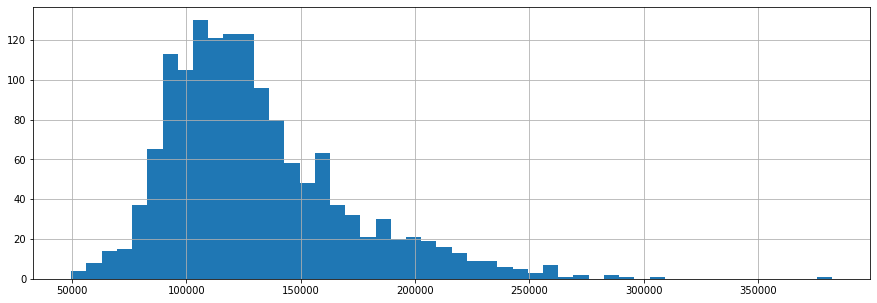

In [128]:
path = "/models"

#loading trained model
lin_model = joblib.load(path+'linear_regression.joblib') 

#predictions
pred = lin_model.predict(data)

#plotting predicted sale prices
plt.figure(figsize=(15,5))
pd.Series(np.exp(pred)).hist(bins=50)
plt.show()

# Problems I am facing

1. re-wrote a lot of code i.e. repetitive coding
2. hard coded a lot of parameters, if parameter changes I have to re-write them again
3. engineered a lot of variables that I actually don't need for modelling
4. additional variables present missing data, I don't know what to do with them
